In [46]:
from tensorflow import keras
import numpy as np
import random
from tensorflow.image import resize
import cv2
from itertools import islice
#from sklearn.preprocessing import LabelBinarizer
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from LeNet5_no_softmax import *
from VGG16_pretrained_no_softmax import *
from utils import *

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Adversarial Training for LeNet

### Load Images

In [2]:
# Loading dataset from keras (ref: https://keras.io/api/datasets/mnist/)
(x_train,y_train),(x_test,y_test)= keras.datasets.mnist.load_data()

# Print shapes
print('x_train shape: ', x_train.shape) # Train images
print('y_train shape: ', y_train.shape) # Train Labels
print('x_test shape: ', x_test.shape) # Test images
print('y_test shape: ', y_test.shape) # Test labels

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


### Resize Training Data

In [3]:
# Resize training images for LeNet5
lenet_xtrain = resize_and_process_images_for_model(x_train, 'lenet5')

### Resize Test Data

In [5]:
# Resize training images for LeNet5
lenet_xtest = resize_and_process_images_for_model(x_test, 'lenet5')

### Load original trained model

In [7]:
# Load original model for DeepFool Attack input
LeNet_model = load_model('model_LeNet_no_softmax.h5')

### Alter training images with DeepFool attack

In [9]:
# For LeNet images
with timeit("Converting LeNet images to adversarial images..."):
    lenet_orig_labels, lenet_adv_images, lenet_adv_perts, lenet_adv_labels, lenet_iterations = deepfool_attack(LeNet_model, lenet_xtrain)

Converting LeNet images to adversarial images... started...
Converting LeNet images to adversarial images... completed. Elapsed time: 28886.24s



#### Save Altered Training Images

In [49]:
import pickle

# Save advesarial data to file
with open('LeNet_Adversarial_Data/adv_mnist_xtrain/Adversarial_train_images/lenet_adv_images.pickle', 'wb') as f:
    pickle.dump(lenet_adv_images, f)
    
with open('LeNet_Adversarial_Data/adv_mnist_xtrain/Adversarial_train_image_labels/lenet_adv_labels.pickle', 'wb') as f:
    pickle.dump(lenet_adv_labels, f)
    
with open('LeNet_Adversarial_Data/adv_mnist_xtrain/Original_train_pred_labels/lenet_orig_labels.pickle', 'wb') as f:
    pickle.dump(lenet_orig_labels, f)

with open('LeNet_Adversarial_Data/adv_mnist_xtrain/Adversarial_train_image_perturberations/lenet_adv_perts.pickle', 'wb') as f:
    pickle.dump(lenet_adv_perts, f)

with open('LeNet_Adversarial_Data/adv_mnist_xtrain/Adversarial_train_image_iterations/lenet_iterations.pickle', 'wb') as f:
    pickle.dump(lenet_iterations, f)

#### How to unload pickle data

In [ ]:
# Example code to reload pickle data
# import pickle

# with open('LeNet_Adversarial_Data/adv_mnist_xtrain/Adversarial_train_images/lenet_adv_images.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     data = pickle.load(f)

#### Preview of Altered Training Images

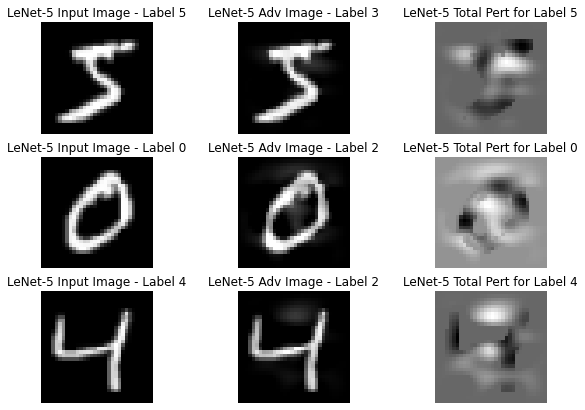

In [10]:
display_adv_images(lenet_xtrain[:3], lenet_adv_images[:3], lenet_orig_labels[0:3], lenet_adv_labels[0:3], lenet_adv_perts[0:3])

### Training the original model with altered train images

In [28]:
# Load LeNet_model for adversarial training
adv_LeNet_model = load_model('model_LeNet_no_softmax.h5')

In [29]:
# Set parameters for training
from sklearn.model_selection import train_test_split

# Initialize parameters
rand_seed = 12345
val_size = 0.2

In [30]:
# Convert images to numpy since output of DeepFool attack is a list
lenet_adv_images_numpy = np.array(lenet_adv_images)
lenet_adv_images_numpy.shape

(60000, 32, 32, 1)

In [31]:
# Create adversarial LeNet5 Training and Validation data set
lenet_adv_train_imgs, lenet_adv_val_imgs, lenet_train_label, lenet_val_label = train_test_split(lenet_adv_images_numpy, y_train, test_size=val_size, random_state=rand_seed)
print('lenet_adv_train_imgs shape: ', lenet_adv_train_imgs.shape)
print('lenet_adv_val_imgs shape: ', lenet_adv_val_imgs.shape)
print('lenet_train_labels shape: ', lenet_train_label.shape)
print('lenet_val_labels shape: ', lenet_val_label.shape)

lenet_adv_train_imgs shape:  (48000, 32, 32, 1)
lenet_adv_val_imgs shape:  (12000, 32, 32, 1)
lenet_train_labels shape:  (48000,)
lenet_val_labels shape:  (12000,)


In [32]:
# TRAIN FUNCTION FOR ADVERSARIAL LENET
def train_lenet_model(model, batch_size=64, n_epochs=20, seed=42):
    # Determine number of samples in training and validation set
    num_train_samples = len(lenet_adv_train_imgs)
    num_vali_samples = len(lenet_adv_val_imgs)
    
    # Compute number of training and validation steps for each epoch
    steps_train = num_train_samples // batch_size
    steps_vali = num_vali_samples // batch_size
    
    # Add 1 more step if there are remaining samples after integer division
    if num_train_samples % batch_size != 0:
        steps_train += 1

    if num_vali_samples % batch_size != 0:
        steps_vali += 1
    
    # Start training
    return model.fit(
        lenet_adv_train_imgs, 
        lenet_train_label,
        steps_per_epoch=steps_train,
        epochs=n_epochs,
        validation_data=(lenet_adv_val_imgs,lenet_val_label),
        validation_steps=steps_vali,
        verbose=1
    )

#### Train the model

In [33]:
import json

lenet_adv_history = train_lenet_model(adv_LeNet_model)
# Store the trained model in file
adv_model_LeNet.save("./adv_model_LeNet_no_softmax.h5")

# Save history to a json file
json.dump(lenet_adv_history.history, open('lenet_adv_history_no_softmax.json', 'w'))

Epoch 1/20
750/750 [==============================] - 13s 16ms/step - loss: 0.2730 - accuracy: 0.8984 - val_loss: 0.1811 - val_accuracy: 0.9408
Epoch 2/20
750/750 [==============================] - 14s 18ms/step - loss: 0.1515 - accuracy: 0.9499 - val_loss: 0.1449 - val_accuracy: 0.9546
Epoch 3/20
750/750 [==============================] - 14s 18ms/step - loss: 0.1192 - accuracy: 0.9618 - val_loss: 0.1198 - val_accuracy: 0.9640
Epoch 4/20
750/750 [==============================] - 14s 18ms/step - loss: 0.1012 - accuracy: 0.9679 - val_loss: 0.1079 - val_accuracy: 0.9663
Epoch 5/20
750/750 [==============================] - 14s 19ms/step - loss: 0.0887 - accuracy: 0.9725 - val_loss: 0.1021 - val_accuracy: 0.9688
Epoch 6/20
750/750 [==============================] - 16s 21ms/step - loss: 0.0782 - accuracy: 0.9762 - val_loss: 0.1010 - val_accuracy: 0.9690
Epoch 7/20
750/750 [==============================] - 15s 20ms/step - loss: 0.0710 - accuracy: 0.9787 - val_loss: 0.0858 - val_accuracy:

### Alter LeNet Test Images

In [17]:
# For LeNet test images
with timeit("Converting LeNet test images to adversarial images..."):
    lenet_test_orig_labels, lenet_test_adv_images, lenet_test_adv_perts, lenet_test_adv_labels, lenet_test_iterations = deepfool_attack(LeNet_model, lenet_xtest)

Converting LeNet test images to adversarial images... started...
Converting LeNet test images to adversarial images... completed. Elapsed time: 4857.46s



#### Save altered test images

In [50]:
# Save advesarial data to file
with open('LeNet_Adversarial_Data/adv_mnist_xtest/Adversarial_test_images/lenet_test_adv_images.pickle', 'wb') as f:
    pickle.dump(lenet_test_adv_images, f)
    
with open('LeNet_Adversarial_Data/adv_mnist_xtest/Adversarial_test_image_labels/lenet_test_adv_labels.pickle', 'wb') as f:
    pickle.dump(lenet_test_adv_labels, f)
    
with open('LeNet_Adversarial_Data/adv_mnist_xtest/Original_test_pred_labels/lenet_test_orig_labels.pickle', 'wb') as f:
    pickle.dump(lenet_test_orig_labels, f)

with open('LeNet_Adversarial_Data/adv_mnist_xtest/Adversarial_test_image_perturberations/lenet_test_adv_perts.pickle', 'wb') as f:
    pickle.dump(lenet_test_adv_perts, f)

with open('LeNet_Adversarial_Data/adv_mnist_xtest/Adversarial_test_image_iterations/lenet_test_iterations.pickle', 'wb') as f:
    pickle.dump(lenet_test_iterations, f)

In [42]:
# Convert images to numpy from list
lenet_test_adv_images_numpy = np.array(lenet_test_adv_images)
lenet_test_adv_images_numpy.shape

(10000, 32, 32, 1)

### Accuracy of Original model on Altered Test Images

In [43]:
LeNet_model = load_model('model_LeNet_no_softmax.h5')

# Alternate way to test
LeNet_loss, LeNet_accuracy = LeNet_model.evaluate(lenet_test_adv_images_numpy, y_test, verbose=1)
print("LeNet Test Accuracy:", LeNet_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.7428 - accuracy: 0.0152
LeNet Test Accuracy: 0.015200000256299973


In [51]:
lenet_adv_xtest_output = LeNet_model.predict(lenet_test_adv_images_numpy)
lenet_adv_xtest_preds = np.argmax(lenet_adv_xtest_output, axis=1)

# Print confusion matrix
print("LeNet Confusion Matrix on Adversarial Images:")
print(confusion_matrix(y_test,lenet_adv_xtest_preds))

# Print classification report
print("\nLeNet Classification Report on Adversarial Images:")
print(classification_report(y_test,lenet_adv_xtest_preds))

LeNet Confusion Matrix on Adversarial Images:
[[ 11  11 172  19  43  88 363 107  49 117]
 [  0   4 101  14   1   1  87 630 278  19]
 [ 40 224   8 298  52   8 108 153 124  17]
 [  7  24 187  11   3 318   2  28 337  93]
 [  1   8  60   6  14  29  91 159 180 434]
 [ 28   5   7 320   5  21 122  29 312  43]
 [101  17 102  17 375  95  13   1 234   3]
 [  3  26 379 229  38  59   0  11  77 206]
 [ 30  24 270 323  34 135  65  42  13  38]
 [  4   9   6  73 472  36   2 212 149  46]]

LeNet Classification Report on Adversarial Images:
              precision    recall  f1-score   support

           0       0.05      0.01      0.02       980
           1       0.01      0.00      0.01      1135
           2       0.01      0.01      0.01      1032
           3       0.01      0.01      0.01      1010
           4       0.01      0.01      0.01       982
           5       0.03      0.02      0.02       892
           6       0.02      0.01      0.01       958
           7       0.01      0.01     

### Accuracy of Adversarial model on Altered Test Images

In [34]:
adv_LeNet_model = load_model('adv_model_LeNet_no_softmax.h5') # Load trained adversarial model

# Alternate way to test
adv_LeNet_loss, adv_LeNet_accuracy = adv_LeNet_model.evaluate(lenet_test_adv_images_numpy, y_test, verbose=1)
print("Adversarial LeNet Test Accuracy:", adv_LeNet_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.0667 - accuracy: 0.9781
Adversarial LeNet Test Accuracy: 0.9781000018119812


In [35]:
adv_lenet_adv_xtest_output = adv_LeNet_model.predict(lenet_test_adv_images_numpy)
adv_lenet_adv_xtest_preds = np.argmax(adv_lenet_adv_xtest_output, axis=1)

# Print confusion matrix
print("Adversarial LeNet Confusion Matrix:")
print(confusion_matrix(y_test,adv_lenet_adv_xtest_preds))

# Print classification report
print("\nAdversarial LeNet Classification Report:")
print(classification_report(y_test,adv_lenet_adv_xtest_preds))

Adversarial LeNet Confusion Matrix:
[[ 975    0    0    0    0    1    2    1    1    0]
 [   0 1125    4    2    0    1    1    0    2    0]
 [   6    0 1012    2    1    0    1    6    4    0]
 [   1    0    0  996    0    7    0    2    2    2]
 [   1    0    1    0  948    0    9    0    0   23]
 [   1    0    0    9    0  879    2    1    0    0]
 [   8    3    0    1    1    8  937    0    0    0]
 [   1    5    5    3    0    0    0 1008    3    3]
 [   8    1    4    8    1   15    6    2  925    4]
 [   4    4    1    5    4    8    0    4    3  976]]

Adversarial LeNet Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.96      0.99      0.97       892
           6

### Accuracy of Adversarial model on Original Test Images

In [52]:
adv_LeNet_model = load_model('adv_model_LeNet_no_softmax.h5')

# Alternate way to test
adv_LeNet_loss_on_orig_data, adv_LeNet_accuracy_on_orig_data = adv_LeNet_model.evaluate(lenet_xtest, y_test, verbose=1)
print("Adversarial LeNet Test Accuracy on Original Data:", adv_LeNet_accuracy_on_orig_data)

313/313 [==============================] - 2s 3ms/step - loss: 0.0451 - accuracy: 0.9868
Adversarial LeNet Test Accuracy on Original Data: 0.9868000149726868


In [53]:
adv_lenet_adv_xtest_output_on_orig_data = adv_LeNet_model.predict(lenet_xtest)
adv_lenet_adv_xtest_preds_on_orig_data = np.argmax(adv_lenet_adv_xtest_output_on_orig_data, axis=1)

# Print confusion matrix
print("Adversarial LeNet Confusion Matrix on Original Data:")
print(confusion_matrix(y_test,adv_lenet_adv_xtest_preds_on_orig_data))

# Print classification report
print("\nAdversarial LeNet Classification Report on Original Data:")
print(classification_report(y_test,adv_lenet_adv_xtest_preds_on_orig_data))

Adversarial LeNet Confusion Matrix on Original Data:
[[ 976    0    0    0    0    0    2    1    1    0]
 [   0 1130    1    1    0    0    2    0    1    0]
 [   3    0 1019    1    0    0    0    7    2    0]
 [   1    0    0 1000    0    3    0    2    4    0]
 [   1    0    2    0  967    0    5    1    0    6]
 [   2    0    0    8    0  878    2    1    1    0]
 [   6    2    0    1    1    4  944    0    0    0]
 [   1    2    5    1    0    0    0 1016    2    1]
 [   4    0    2    3    1    1    1    2  958    2]
 [   3    4    1    6    4    5    0    4    2  980]]

Adversarial LeNet Classification Report on Original Data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.9